# 序言
<font size=5>如何在用C++部署的时候防止辛苦训练的模型泄露？深度学习模型该如何保密？</font>

<font size=5>本文介绍了一种PaddleX提供的简单模型加密方法。虽然距绝对保密还有一定差距，但是毕竟解决了有无问题。</font>

<font size=5>本周是国家网络安全宣传周，不妨看看飞桨是如何让深度学习模型变得更安全的～～走起～～</font>


## 项目简介

前置项目：[安全帽佩戴检测模型训练与一键部署（PaddleX、HubServing）](https://aistudio.baidu.com/aistudio/projectdetail/742090)介绍了基于PaddleX的yolov3_darknet53安全帽检测迁移学习实现。

安全帽佩戴检测是计算机视觉在工业安全领域应用的典型场景，本文使用PaddleX进行pp-yolo迁移学习训练，并提供了Python部署、本地C++模型加密部署和PaddleHub-Serving服务化部署三种部署方式。


在本文中，也对pp-yolo和yolov3_darknet53在安全帽检测数据集上的迁移学习表现进行了对比。

## 关于本项目

> 针对项目还存在的改进空间，如其它环境的加密部署方式等，希望大家多交流观点、介绍经验，共同学习进步。[个人主页](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/90149)

# 环境准备
## 安装工具库

In [1]:
!pip install ipywidgets

## 解压数据集

In [2]:
!mkdir MyDataset

In [3]:
!unzip data/data50329/HelmetDetection.zip -d ./MyDataset

## 切分数据集
### 方案一：使用最新PaddleX的develop分支（不推荐）
实现方式已在前置项目[安全帽佩戴检测模型训练与一键部署（PaddleX、HubServing）](https://aistudio.baidu.com/aistudio/projectdetail/742090)中介绍。

In [ ]:
# !paddlex --split_dataset --format VOC --dataset_dir MyDataset --val_value 0.2 --test_value 0.1

Dataset Split Done.
Train samples: 3500
Eval samples: 1000
Test samples: 500
Split files saved in MyDataset


### 方案二：参考develop分支的voc_split.py重写数据集切分代码
该做法步骤如下：
1. 从pip安装PaddleX
2. 将`voc_split.py`import的方法一一找出，在Notebook中运行
3. 修改voc_split.py切分数据集时对应的文件目录名

In [2]:
# pip安装PaddleX
!pip install paddlex

In [5]:
# PaddleX/paddlex/tools/dataset_split/utils.py

# Copyright (c) 2020 PaddlePaddle Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import os.path as osp
from PIL import Image
import numpy as np
import json


class MyEncoder(json.JSONEncoder):
    # 调整json文件存储形式
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def list_files(dirname):
    """ 列出目录下所有文件（包括所属的一级子目录下文件）

    Args:
        dirname: 目录路径
    """

    def filter_file(f):
        if f.startswith('.'):
            return True
        return False

    all_files = list()
    dirs = list()
    for f in os.listdir(dirname):
        if filter_file(f):
            continue
        if osp.isdir(osp.join(dirname, f)):
            dirs.append(f)
        else:
            all_files.append(f)
    for d in dirs:
        for f in os.listdir(osp.join(dirname, d)):
            if filter_file(f):
                continue
            if osp.isdir(osp.join(dirname, d, f)):
                continue
            all_files.append(osp.join(d, f))
    return all_files


def is_pic(filename):
    """ 判断文件是否为图片格式

    Args:
        filename: 文件路径
    """
    suffixes = {'JPEG', 'jpeg', 'JPG', 'jpg', 'BMP', 'bmp', 'PNG', 'png'}
    suffix = filename.strip().split('.')[-1]
    if suffix not in suffixes:
        return False
    return True


def replace_ext(filename, new_ext):
    """ 替换文件后缀

    Args:
        filename: 文件路径
        new_ext: 需要替换的新的后缀
    """
    items = filename.split(".")
    items[-1] = new_ext
    new_filename = ".".join(items)
    return new_filename


def read_seg_ann(pngfile):
    """ 解析语义分割的标注png图片

    Args:
        pngfile: 包含标注信息的png图片路径
    """
    grt = np.asarray(Image.open(pngfile))
    labels = list(np.unique(grt))
    if 255 in labels:
        labels.remove(255)
    return labels


In [6]:
# PaddleX/paddlex/utils/logging.py

# copyright (c) 2020 PaddlePaddle Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import time
import os
import sys
import colorama
from colorama import init
import paddlex

init(autoreset=True)
levels = {0: 'ERROR', 1: 'WARNING', 2: 'INFO', 3: 'DEBUG'}


def log(level=2, message="", use_color=False):
    current_time = time.time()
    time_array = time.localtime(current_time)
    current_time = time.strftime("%Y-%m-%d %H:%M:%S", time_array)
    if paddlex.log_level >= level:
        if use_color:
            print("\033[1;31;40m{} [{}]\t{}\033[0m".format(
                current_time, levels[level], message).encode("utf-8").decode(
                    "latin1"))
        else:
            print("{} [{}]\t{}".format(current_time, levels[level], message)
                  .encode("utf-8").decode("latin1"))
        sys.stdout.flush()


def debug(message="", use_color=False):
    log(level=3, message=message, use_color=use_color)


def info(message="", use_color=False):
    log(level=2, message=message, use_color=use_color)


def warning(message="", use_color=True):
    log(level=1, message=message, use_color=use_color)


def error(message="", use_color=True, exit=True):
    log(level=0, message=message, use_color=use_color)
    if exit:
        sys.exit(-1)


2020-09-13 10:07:00,072-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2020-09-13 10:07:00,691-INFO: generated new fontManager


In [7]:
# Copyright (c) 2020 PaddlePaddle Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os.path as osp
import random
import xml.etree.ElementTree as ET


def split_voc_dataset(dataset_dir, val_percent, test_percent, save_dir):
    # 注意图片目录和标注目录名已全部修改
    if not osp.exists(osp.join(dataset_dir, "images")):
        logging.error("\'images\' is not found in {}!".format(dataset_dir))
    if not osp.exists(osp.join(dataset_dir, "annotations")):
        logging.error("\'annotations\' is not found in {}!".format(
            dataset_dir))

    all_image_files = list_files(osp.join(dataset_dir, "images"))

    image_anno_list = list()
    label_list = list()
    for image_file in all_image_files:
        if not is_pic(image_file):
            continue
        anno_name = replace_ext(image_file, "xml")
        if osp.exists(osp.join(dataset_dir, "annotations", anno_name)):
            image_anno_list.append([image_file, anno_name])
            try:
                tree = ET.parse(
                    osp.join(dataset_dir, "annotations", anno_name))
            except:
                raise Exception("文件{}不是一个良构的xml文件，请检查标注文件".format(
                    osp.join(dataset_dir, "annotations", anno_name)))
            objs = tree.findall("object")
            for i, obj in enumerate(objs):
                cname = obj.find('name').text
                if not cname in label_list:
                    label_list.append(cname)
        else:
            logging.error("The annotation file {} doesn't exist!".format(
                anno_name))

    random.shuffle(image_anno_list)
    image_num = len(image_anno_list)
    val_num = int(image_num * val_percent)
    test_num = int(image_num * test_percent)
    train_num = image_num - val_num - test_num

    train_image_anno_list = image_anno_list[:train_num]
    val_image_anno_list = image_anno_list[train_num:train_num + val_num]
    test_image_anno_list = image_anno_list[train_num + val_num:]

    with open(
            osp.join(save_dir, 'train_list.txt'), mode='w',
            encoding='utf-8') as f:
        for x in train_image_anno_list:
            file = osp.join("images", x[0])
            label = osp.join("annotations", x[1])
            f.write('{} {}\n'.format(file, label))
    with open(
            osp.join(save_dir, 'val_list.txt'), mode='w',
            encoding='utf-8') as f:
        for x in val_image_anno_list:
            file = osp.join("images", x[0])
            label = osp.join("annotations", x[1])
            f.write('{} {}\n'.format(file, label))
    if len(test_image_anno_list):
        with open(
                osp.join(save_dir, 'test_list.txt'), mode='w',
                encoding='utf-8') as f:
            for x in test_image_anno_list:
                file = osp.join("images", x[0])
                label = osp.join("annotations", x[1])
                f.write('{} {}\n'.format(file, label))
    with open(
            osp.join(save_dir, 'labels.txt'), mode='w', encoding='utf-8') as f:
        for l in sorted(label_list):
            f.write('{}\n'.format(l))

    return train_num, val_num, test_num


if __name__ == "__main__":
    # 切分数据集
    split_voc_dataset('MyDataset', 0.2, 0.1, 'MyDataset')


# pp-yolo与yolov3_darknet53训练性能比较
这里直接使用[官方文档pp-yolo训练代码](https://github.com/PaddlePaddle/PaddleX/blob/develop/tutorials/train/object_detection/ppyolo.py)。

VisualDL训练过程请查看`output/ppyolo/vdl_log`目录。

1. loss下降趋势

<center class = "half">
<img src=https://ai-studio-static-online.cdn.bcebos.com/5c621c45924d4904ad54b5eef223b59e22cffdc0ce9d46d6827f205109cac385 width=50% align=left><img src=https://ai-studio-static-online.cdn.bcebos.com/19d0b3f2ef7d4a8f9d4707ce1270b50e7b69d9afbd324c949e06ee7808fbe1c2 width=50% align=right>
</center>

2. 学习率变化

<center class = "half">
<img src=https://ai-studio-static-online.cdn.bcebos.com/959162b0035447698b40b5ef789e60273540310d957548429689cabcbd8a02f0 width=50% align=left><img src=https://ai-studio-static-online.cdn.bcebos.com/da67f4062831452392f50c8b754d340d4fb8b31cc6da47b89094b43d9432de45 width=50% align=right>
</center>

3. 验证集上bbox_map变化

<center class = "half">
<img src=https://ai-studio-static-online.cdn.bcebos.com/a7201bd8f6d54e49989165bff311acc90a5da1d97acb45e88154659e910e9400 width=50% align=left><img src=https://ai-studio-static-online.cdn.bcebos.com/9fdde2c046394465a973a2dac23aa22377f914a7cf584637a572bf82bf1b166e width=50% align=right>
</center>



## 开始训练

In [1]:
# 环境变量配置，用于控制是否使用GPU
# 说明文档：https://paddlex.readthedocs.io/zh_CN/develop/appendix/parameters.html#gpu
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from paddlex.det import transforms
import paddlex as pdx

# 定义训练和验证时的transforms
# API说明 https://paddlex.readthedocs.io/zh_CN/develop/apis/transforms/det_transforms.html
train_transforms = transforms.Compose([
    transforms.MixupImage(mixup_epoch=250), transforms.RandomDistort(),
    transforms.RandomExpand(), transforms.RandomCrop(), transforms.Resize(
        target_size=608, interp='RANDOM'), transforms.RandomHorizontalFlip(),
    transforms.Normalize()
])

eval_transforms = transforms.Compose([
    transforms.Resize(
        target_size=608, interp='CUBIC'), transforms.Normalize()
])

# 定义训练和验证所用的数据集
# API说明：https://paddlex.readthedocs.io/zh_CN/develop/apis/datasets.html#paddlex-datasets-vocdetection
train_dataset = pdx.datasets.VOCDetection(
    data_dir='MyDataset',
    file_list='MyDataset/train_list.txt',
    label_list='MyDataset/labels.txt',
    transforms=train_transforms,
    shuffle=True)
eval_dataset = pdx.datasets.VOCDetection(
    data_dir='MyDataset',
    file_list='MyDataset/val_list.txt',
    label_list='MyDataset/labels.txt',
    transforms=eval_transforms)

# 初始化模型，并进行训练
# 可使用VisualDL查看训练指标，参考https://paddlex.readthedocs.io/zh_CN/develop/train/visualdl.html
num_classes = len(train_dataset.labels)

# API说明: https://paddlex.readthedocs.io/zh_CN/develop/apis/models/detection.html#paddlex-det-yolov3
model = pdx.det.PPYOLO(num_classes=num_classes)

# API说明: https://paddlex.readthedocs.io/zh_CN/develop/apis/models/detection.html#train
# 各参数介绍与调整说明：https://paddlex.readthedocs.io/zh_CN/develop/appendix/parameters.html
model.train(
    num_epochs=270,
    train_dataset=train_dataset,
    train_batch_size=8,
    eval_dataset=eval_dataset,
    learning_rate=0.000125,
    lr_decay_epochs=[210, 240],
    save_dir='output/ppyolo',
    use_vdl=True)

# Python部署
PaddleX已经集成了基于Python的高性能预测接口，下面演示单张图片和视频流的预测效果。
## 导出预测模型

In [9]:
!paddlex --export_inference --model_dir=./output/ppyolo/best_model --save_dir=./inference_model

[09-14 00:02:43 MainThread @logger.py:224] Argv: /opt/conda/envs/python35-paddle120-env/bin/paddlex --export_inference --model_dir=./output/ppyolo/best_model --save_dir=./inference_model
W0914 00:02:44.759682  6403 device_context.cc:252] Please NOTE: device: 0, CUDA Capability: 70, Driver API Version: 9.2, Runtime API Version: 9.0
W0914 00:02:44.765246  6403 device_context.cc:260] device: 0, cuDNN Version: 7.6.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/io.py:1998: UserWarning: This list is not set, Because of Paramerter not found in program. There are: create_parameter_0.w_0 create_parameter_1.w_0 create_parameter_2.w_0 create_parameter_3.w_0 create_parameter_4.w_0 create_parameter_5.w_0 create_parameter_6.w_0 create_parameter_7.w_0 create_parameter_8.w_0 create_parameter_9.w_0 create_parameter_10.w_0 create_parameter_11.w_0 create_parameter_12.w_0 create_parameter_13.w_0 create_parameter_14.w_0 create_parameter_15.w_0 create_parameter_16.w_0 creat

### 单张图片预测
选择一张测试集中的图片，查看预测效果

In [10]:
import paddlex as pdx
predictor = pdx.deploy.Predictor('./inference_model')
result = predictor.predict(image='MyDataset/images/hard_hat_workers1457.png')

2020-09-14 00:03:07 [WARNING]	HRNet/DeepLabv3p/PPYOLO are not supported for the use of mkldnn



/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


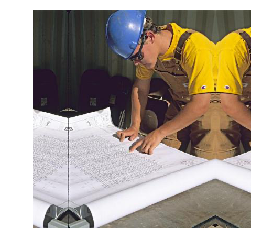

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt # plt 用于显示图片
import numpy as np
import cv2

# 读取原始图片
origin_pic = cv2.imread('MyDataset/images/hard_hat_workers1457.png')
origin_pic = cv2.cvtColor(origin_pic, cv2.COLOR_BGR2RGB)
plt.imshow(origin_pic)
plt.axis('off') # 不显示坐标轴
plt.show()

In [12]:
result

[{'category_id': 1,
  'bbox': [125.0842514038086,
   0.0384979248046875,
   136.88593292236328,
   115.65148162841797],
  'score': 0.9950428009033203,
  'category': 'helmet'},
 {'category_id': 1,
  'bbox': [390.4376525878906,
   27.37880516052246,
   25.49139404296875,
   45.28906440734863],
  'score': 0.12913084030151367,
  'category': 'helmet'},
 {'category_id': 1,
  'bbox': [134.69830322265625, 0.0, 129.36032104492188, 115.4359130859375],
  'score': 0.08461114019155502,
  'category': 'helmet'},
 {'category_id': 2,
  'bbox': [154.33670043945312, 0.0, 236.26812744140625, 342.99615478515625],
  'score': 0.07235386967658997,
  'category': 'person'},
 {'category_id': 1,
  'bbox': [193.6173095703125,
   188.1810760498047,
   48.258544921875,
   46.7227783203125],
  'score': 0.06879084557294846,
  'category': 'helmet'},
 {'category_id': 2,
  'bbox': [355.259033203125,
   16.935226440429688,
   55.0848388671875,
   294.5183868408203],
  'score': 0.05975065752863884,
  'category': 'person'},

### 视频流预测
在AI Studio中不能演示实时效果，因此采用将预测图片保存再合成视频的形式。同样需要重写`paddlex.det.visualize()`方法

In [23]:
??paddlex.det.visualize

In [13]:
def draw_bbox_mask(image, results, threshold=0.5):
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib as mpl
    import matplotlib.figure as mplfigure
    import matplotlib.colors as mplc
    from matplotlib.backends.backend_agg import FigureCanvasAgg

    # refer to  https://github.com/facebookresearch/detectron2/blob/master/detectron2/utils/visualizer.py
    def _change_color_brightness(color, brightness_factor):
        assert brightness_factor >= -1.0 and brightness_factor <= 1.0
        color = mplc.to_rgb(color)
        polygon_color = colorsys.rgb_to_hls(*mplc.to_rgb(color))
        modified_lightness = polygon_color[1] + (brightness_factor *
                                                 polygon_color[1])
        modified_lightness = 0.0 if modified_lightness < 0.0 else modified_lightness
        modified_lightness = 1.0 if modified_lightness > 1.0 else modified_lightness
        modified_color = colorsys.hls_to_rgb(
            polygon_color[0], modified_lightness, polygon_color[2])
        return modified_color

    _SMALL_OBJECT_AREA_THRESH = 1000
    # setup figure
    width, height = image.shape[1], image.shape[0]
    scale = 1
    fig = mplfigure.Figure(frameon=False)
    dpi = fig.get_dpi()
    fig.set_size_inches(
        (width * scale + 1e-2) / dpi,
        (height * scale + 1e-2) / dpi, )
    canvas = FigureCanvasAgg(fig)
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0])
    ax.axis("off")
    ax.set_xlim(0.0, width)
    ax.set_ylim(height)
    default_font_size = max(np.sqrt(height * width) // 90, 10 // scale)
    linewidth = max(default_font_size / 4, 1)

    labels = list()
    for dt in np.array(results):
        if dt['category'] not in labels:
            labels.append(dt['category'])
    color_map = get_color_map_list(256)

    keep_results = []
    areas = []
    for dt in np.array(results):
        cname, bbox, score = dt['category'], dt['bbox'], dt['score']
        if score < threshold:
            continue
        keep_results.append(dt)
        areas.append(bbox[2] * bbox[3])
    areas = np.asarray(areas)
    sorted_idxs = np.argsort(-areas).tolist()
    keep_results = [keep_results[k]
                    for k in sorted_idxs] if len(keep_results) > 0 else []

    for dt in np.array(keep_results):
        cname, bbox, score = dt['category'], dt['bbox'], dt['score']
        xmin, ymin, w, h = bbox
        xmax = xmin + w
        ymax = ymin + h

        color = tuple(color_map[labels.index(cname) + 2])
        color = [c / 255. for c in color]
        # draw bbox
        ax.add_patch(
            mpl.patches.Rectangle(
                (xmin, ymin),
                w,
                h,
                fill=False,
                edgecolor=color,
                linewidth=linewidth * scale,
                alpha=0.8,
                linestyle="-", ))

        # draw mask
        if 'mask' in dt:
            mask = dt['mask']
            mask = np.ascontiguousarray(mask)
            res = cv2.findContours(
                mask.astype("uint8"), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
            hierarchy = res[-1]
            alpha = 0.5
            if hierarchy is not None:
                has_holes = (hierarchy.reshape(-1, 4)[:, 3] >= 0).sum() > 0
                res = res[-2]
                res = [x.flatten() for x in res]
                res = [x for x in res if len(x) >= 6]
                for segment in res:
                    segment = segment.reshape(-1, 2)
                    edge_color = mplc.to_rgb(color) + (1, )
                    polygon = mpl.patches.Polygon(
                        segment,
                        fill=True,
                        facecolor=mplc.to_rgb(color) + (alpha, ),
                        edgecolor=edge_color,
                        linewidth=max(default_font_size // 15 * scale, 1), )
                    ax.add_patch(polygon)

        # draw label
        text_pos = (xmin, ymin)
        horiz_align = "left"
        instance_area = w * h
        if (instance_area < _SMALL_OBJECT_AREA_THRESH * scale or
                h < 40 * scale):
            if ymin >= height - 5:
                text_pos = (xmin, ymin)
            else:
                text_pos = (xmin, ymax)
        height_ratio = h / np.sqrt(height * width)
        font_size = (np.clip((height_ratio - 0.02) / 0.08 + 1, 1.2,
                             2) * 0.5 * default_font_size)
        text = "{} {:.2f}".format(cname, score)
        color = np.maximum(list(mplc.to_rgb(color)), 0.2)
        color[np.argmax(color)] = max(0.8, np.max(color))
        color = _change_color_brightness(color, brightness_factor=0.7)
        ax.text(
            text_pos[0],
            text_pos[1],
            text,
            size=font_size * scale,
            family="sans-serif",
            bbox={
                "facecolor": "black",
                "alpha": 0.8,
                "pad": 0.7,
                "edgecolor": "none"
            },
            verticalalignment="top",
            horizontalalignment=horiz_align,
            color=color,
            zorder=10,
            rotation=0, )

    s, (width, height) = canvas.print_to_buffer()
    buffer = np.frombuffer(s, dtype="uint8")

    img_rgba = buffer.reshape(height, width, 4)
    rgb, alpha = np.split(img_rgba, [3], axis=2)

    try:
        import numexpr as ne
        visualized_image = ne.evaluate(
            "image * (1 - alpha / 255.0) + rgb * (alpha / 255.0)")
    except ImportError:
        alpha = alpha.astype("float32") / 255.0
        visualized_image = image * (1 - alpha) + rgb * alpha

    visualized_image = visualized_image.astype("uint8")

    return visualized_image

In [14]:
def get_color_map_list(num_classes):
    """ Returns the color map for visualizing the segmentation mask,
        which can support arbitrary number of classes.
    Args:
        num_classes: Number of classes
    Returns:
        The color map
    """
    color_map = num_classes * [0, 0, 0]
    for i in range(0, num_classes):
        j = 0
        lab = i
        while lab:
            color_map[i * 3] |= (((lab >> 0) & 1) << (7 - j))
            color_map[i * 3 + 1] |= (((lab >> 1) & 1) << (7 - j))
            color_map[i * 3 + 2] |= (((lab >> 2) & 1) << (7 - j))
            j += 1
            lab >>= 3
    color_map = [color_map[i:i + 3] for i in range(0, len(color_map), 3)]
    return color_map

In [15]:
def visualize(image, result, threshold=0.5, img_num=0,save_dir='./'):
    """
        Visualize bbox and mask results
    """

    if isinstance(image, np.ndarray):
        image_name = str(img_num) + '.jpg'
    else:
        image_name = os.path.split(image)[-1]
        image = cv2.imread(image)

    image = draw_bbox_mask(image, result, threshold=threshold)
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        out_path = os.path.join(save_dir, '{}'.format(image_name))
        cv2.imwrite(out_path, image)
        print('The visualized result is saved as {}'.format(out_path))
    else:
        return image

In [16]:
import time
import os
import sys
import colorama
from colorama import init
import paddlex

init(autoreset=True)
levels = {0: 'ERROR', 1: 'WARNING', 2: 'INFO', 3: 'DEBUG'}


def log(level=2, message="", use_color=False):
    current_time = time.time()
    time_array = time.localtime(current_time)
    current_time = time.strftime("%Y-%m-%d %H:%M:%S", time_array)
    if paddlex.log_level >= level:
        if use_color:
            print("\033[1;31;40m{} [{}]\t{}\033[0m".format(
                current_time, levels[level], message).encode("utf-8").decode(
                    "latin1"))
        else:
            print("{} [{}]\t{}".format(current_time, levels[level], message)
                  .encode("utf-8").decode("latin1"))
        sys.stdout.flush()


def debug(message="", use_color=False):
    log(level=3, message=message, use_color=use_color)


def info(message="", use_color=False):
    log(level=2, message=message, use_color=use_color)


def warning(message="", use_color=True):
    log(level=1, message=message, use_color=use_color)


def error(message="", use_color=True, exit=True):
    log(level=0, message=message, use_color=use_color)
    if exit:
        sys.exit(-1)


In [2]:
import cv2
import paddlex as pdx
import numpy as np
import colorsys
import os

predictor = pdx.deploy.Predictor('./inference_model')
cap = cv2.VideoCapture('./hatdet.mp4')
i = 1
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        result = predictor.predict(frame)
        print(i)
        vis_img = visualize(frame, result, threshold=0.4, img_num=i, save_dir='hatdet')
        i += 1
        # 本地环境可以实时查看安全帽检测效果
        # cv2.imshow('hatdet', vis_img)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()

In [18]:
# 将图片合成视频
!ffmpeg -f image2 -i ./hatdet/%d.jpg -vcodec libx264 -r 30 ppyolo.mp4

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

我们可以发现，pp-yolo其实把普通的帽子也识别成安全帽了，相比yolov3_darknet53，各有改进空间。
<center class = "half">
<img src=https://ai-studio-static-online.cdn.bcebos.com/8e7e1caf21bc45b5b33f83b7a59f7ed042717bb7c6f64fef80722fd48785077f width=50% align=left><img src=https://ai-studio-static-online.cdn.bcebos.com/a417f8c783f243348f0107e416f4e2873403c90305a64a139fb4fa673382b9a2 width=50% align=right>
</center>

In [19]:
import IPython
IPython.display.Video('ppyolo.mp4')

#  模型加密部署（Linux平台）
## 简介
来源：[PaddleX官方文档](https://github.com/paddlepaddle/PaddleX/blob/develop/docs/deploy/server/encryption.md)

（1）加密算法的选择和支持的库

一般使用OpenSSL库来支持数据的加解密，OpenSSL提供了大量的加解密算法，包括对称加密算法（AES等）和非对称加密算法（RSA等）。

两种算法使用的场景不同，**非对称加密算法一般应用于数字签名和密钥协商的场景下**，而**对称加密算法一般应用于纯数据加密场景**，性能更优。在对模型的加密过程中使用对称加密算法。

> 笔者注：简单来说，非对称加密算法保密性更好，暴力破解难度远大于对称加密算法，但这是以时间为代价换来的，非对称加密算法不适合大规模数据的加密。

以下对模型加密场景实现的说明中以开发一个C/C++库为基础，采用AES对称加密算法，为了加解密前后能够快速判断解密是否成功，使用AES-GCM加解密模式，在密钥的安全性上使用长度为256位的密钥数据。

（2）实现模型保护的一般步骤：

![file](https://gitee.com/paddlepaddle/PaddleX/raw/develop/docs/deploy/images/encryption_process.png)

下面是对提供的C/C++加解密库内部实现的中文描述，参考以下步骤可以实现一套加解密库来适应自己的场景并通过内存数据加载到Paddle Inference预测库中

> 1）考虑到加密的模型文件解密后需要从内存加载数据，使用conbine的模式生成模型文件和参数文件。
>
> 2）项目集成OpenSSL，使用静态库的形式。
>
> 3）实现AES算法接口，借助OpenSSL提供的EVP接口，在EVP接口中指定算法类型，算法使用对称加解密算法中的AES，加解密模式使用AES-GCM， 密钥长度为256位，AES-GCM的实现可以参考官方提供的例子自己进行封装接口：[AES-GCM实现](https://wiki.openssl.org/index.php/EVP_Authenticated_Encryption_and_Decryption)。
>
> 4）利用OpenSSL库实现SHA256摘要算法，这部分下面有用（可选）。关于SHA256的hash计算可以参考OpenSSL提供的example：[OpenSSL 信息摘要例子](https://wiki.openssl.org/index.php/EVP_Message_Digests)。
>
> 5）在模型加密环节直接对model文件和params文件的数据内容进行加密后保存到新的文件，为了新的文件能够被区分和可迭代，除了加密后的数据外还添加了头部信息，比如为了判断该文件类型使用固定的魔数作为文件的开头；为了便于后面需求迭代写入版本号以示区别；为了能够在解密时判断是否采用了相同的密钥将加密时的密钥进行SHA256计算后存储；这三部分构成了目前加密后文件的头部信息。加密后的文件包含头部信息 + 密文信息。
>
> 6）在模型解密环节根据加密后的文件读取相关的加密数据到内存中，对内存数据使用AES算法进行解密，注意解密时需要采用与加密时一致的加密算法和加密的模式，以及密钥的数据和长度，否则会导致解密后数据错误。
>
> 7）集成模型预测的C/C++库，在具体使用预测时一般涉及paddle::AnalysisConfig和paddle::Predictor，为了能够从内存数据中直接load解密后的模型明文数据（避免模型解密后创建临时文件），这里需要将AnalysisConfig的模型加载函数从SetModel替换为SetModelBuffer来实现从内存中加载模型数据。

需要注意的是，在本方案中，密钥集成在上层预测服务的代码中。故模型的安全强度等同于代码抵御逆向调试的强度。为了保护密钥和模型的安全，开发者还需对自己的应用进行加固保护。常见的应用加固手段有：代码混淆，二进制文件加壳 等等，亦或将加密机制更改为AES白盒加密技术来保护密钥。这类技术领域内有大量商业和开源产品可供选择，此处不一一赘述。
## 下载并解压加密工具
[Linux版本 PaddleX模型加密工具](https://bj.bcebos.com/paddlex/tools/1.2.0/paddlex-encryption.zip)，在本地编译脚本时会自动下载该版本加密工具，但是在AI Studio编译失败，因此这里选择手动下载。

In [26]:
!wget https://bj.bcebos.com/paddlex/tools/1.2.0/paddlex-encryption.zip

--2020-09-14 00:17:31--  https://bj.bcebos.com/paddlex/tools/1.2.0/paddlex-encryption.zip
Resolving bj.bcebos.com (bj.bcebos.com)... 182.61.200.229, 182.61.200.195, 2409:8c00:6c21:10ad:0:ff:b00e:67d
Connecting to bj.bcebos.com (bj.bcebos.com)|182.61.200.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3972031 (3.8M) [application/octet-stream]
Saving to: ‘paddlex-encryption.zip’

paddlex-encryption. 100%[===================>]   3.79M  8.38MB/s    in 0.5s    

2020-09-14 00:17:32 (8.38 MB/s) - ‘paddlex-encryption.zip’ saved [3972031/3972031]



In [27]:
!unzip paddlex-encryption.zip

Archive:  paddlex-encryption.zip
   creating: paddlex-encryption/
   creating: paddlex-encryption/include/
  inflating: paddlex-encryption/include/paddle_model_encrypt.h  
  inflating: paddlex-encryption/include/paddle_model_decrypt.h  
  inflating: paddlex-encryption/include/model_code.h  
  inflating: paddlex-encryption/.DS_Store  
  inflating: paddlex-encryption/README  
   creating: paddlex-encryption/tool/
  inflating: paddlex-encryption/tool/paddle_encrypt_tool  
   creating: paddlex-encryption/lib/
  inflating: paddlex-encryption/lib/libpmodel-encrypt.so  
  inflating: paddlex-encryption/lib/libpmodel-decrypt.so  


## 导出PaddleX加密模型
加密完成后，加密过的模型会保存至指定的`-save_dir`下，包含`__model__.encrypted`、`__params__.encrypted`和`model.yml`三个文件，同时生成密钥信息，命令输出如下，密钥为`onHEuCBj4kYLuRmDdPtbODXpvdYaVRLRB/eWhkopx8U=`

In [28]:
! ./paddlex-encryption/tool/paddle_encrypt_tool -model_dir /home/aistudio/inference_model -save_dir /home/aistudio/paddlex_encrypted_model

Output: Encryption key: 
	onHEuCBj4kYLuRmDdPtbODXpvdYaVRLRB/eWhkopx8U=
Success, Encrypt __model__, __params__ to /home/aistudio/paddlex_encrypted_model(dir) success!


## 本地Linux平台部署加密模型
> 注：以下内容需要在本地环境完成，其中一个关键原因是AI Studio上的gcc版本过高，同时没有`sudo`权限降低gcc版本。
### PaddleX文档要求的前置条件
- G++ 4.8.2 ~ 4.9.4
- CUDA 9.0 / CUDA 10.0, CUDNN 7+ （仅在使用GPU版本的预测库时需要）
- CMake 3.0+

实际完成本地测试的部署环境
- G++ 4.8.5
- CUDA 10.2，CUDNN 7.6.5
- CMake 3.10.2
- 有网络环境

### 安装GCC
参考：[GCC降级和升级](https://blog.csdn.net/qianqiying/article/details/81585136)

本地环境GCC版本过高，编译时出现了报错，因此对GCC进行降级
1. 安装gcc4.8
```bash
sudo apt-get install -y gcc-4.8
sudo apt-get install -y g++-4.8
```
2. 重新建立软连接
```bash
cd /usr/bin    #进入/usr/bin文件夹下
sudo rm -r gcc  #移除之前的软连接
sudo ln -sf gcc-4.8 gcc #建立gcc4.7的软连接
sudo rm -r g++  #同gcc
sudo ln -sf g++-4.8 g++
```
3. 确认gcc版本
```bash
gcc --version #查看gcc版本
```
```bash
gcc (Ubuntu 4.8.5-4ubuntu8) 4.8.5
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
```
### 安装Linux预测库

#### 1. 拉取PaddleX模型库

```bash
git clone https://gitee.com/paddlepaddle/PaddleX.git
```
**说明**：其中`C++`预测代码在`/root/projects/PaddleX/deploy/cpp` 目录，该目录不依赖任何`PaddleX`下其他目录。

#### 2. 下载PaddlePaddle C++ 预测库 paddle_inference

根据[PaddleX文档介绍](https://gitee.com/paddlepaddle/PaddleX/blob/develop/docs/deploy/server/cpp/linux.md)与[飞桨官网的说明](https://www.paddlepaddle.org.cn/documentation/docs/zh/develop/advanced_guide/inference_deployment/inference/build_and_install_lib_cn.html#id12)直接选择合适的版本进行安装
> **注意:** 预编译版本除`nv-jetson-cuda10-cudnn7.5-trt5` 以外其它包都是基于`GCC 4.8.5`编译，使用高版本`GCC`可能存在 `ABI`兼容性问题，建议降级或[自行编译预测库](https://www.paddlepaddle.org.cn/documentation/docs/zh/develop/advanced_guide/inference_deployment/inference/build_and_install_lib_cn.html#id12)。

在本文中，使用的是`ubuntu14.04_cuda10.0_cudnn7_avx_mkl`预测库(1.8.4版本)

下载安装包后，解压到`PaddleX/deploy/cpp`目录下，下载并解压后`PaddleX/deploy/cpp/fluid_inference`目录包含内容为：
```
fluid_inference
├── paddle # paddle核心库和头文件
|
├── third_party # 第三方依赖库和头文件
|
└── version.txt # 版本和编译信息
```

#### 3. 编译
将工作目录切换到`PaddleX/deploy/cpp`目录下之后，只需执行build脚本即可开始编译。
```bash
sh scripts/build.sh
```
$\color{#FF3030}{但是！需要先配置好`scripts/build.sh`，否则在预测时会出现报错！}$
脚本注释比较清晰：
```bash
# 是否使用GPU(即是否使用 CUDA)
WITH_GPU=OFF
# 使用MKL or openblas
WITH_MKL=ON
# 是否集成 TensorRT(仅WITH_GPU=ON 有效)
WITH_TENSORRT=OFF
# TensorRT 的路径，如果需要集成TensorRT，需修改为您实际安装的TensorRT路径
TENSORRT_DIR=/root/projects/TensorRT/
# Paddle 预测库路径, 请修改为您实际安装的预测库路径
PADDLE_DIR=/root/projects/fluid_inference
# Paddle 的预测库是否使用静态库来编译
# 使用TensorRT时，Paddle的预测库通常为动态库
WITH_STATIC_LIB=OFF
# CUDA 的 lib 路径
CUDA_LIB=/usr/local/cuda/lib64
# CUDNN 的 lib 路径
CUDNN_LIB=/usr/local/cuda/lib64

# 是否加载加密后的模型
WITH_ENCRYPTION=ON
# 加密工具的路径, 如果使用自带预编译版本可不修改
sh $(pwd)/scripts/bootstrap.sh # 下载预编译版本的加密工具
ENCRYPTION_DIR=$(pwd)/paddlex-encryption

# OPENCV 路径, 如果使用自带预编译版本可不修改
sh $(pwd)/scripts/bootstrap.sh  # 下载预编译版本的opencv
OPENCV_DIR=$(pwd)/deps/opencv3gcc4.8/

# 以下无需改动
rm -rf build
mkdir -p build
cd build
cmake .. \
    -DWITH_GPU=${WITH_GPU} \
    -DWITH_MKL=${WITH_MKL} \
    -DWITH_TENSORRT=${WITH_TENSORRT} \
    -DWITH_ENCRYPTION=${WITH_ENCRYPTION} \
    -DTENSORRT_DIR=${TENSORRT_DIR} \
    -DPADDLE_DIR=${PADDLE_DIR} \
    -DWITH_STATIC_LIB=${WITH_STATIC_LIB} \
    -DCUDA_LIB=${CUDA_LIB} \
    -DCUDNN_LIB=${CUDNN_LIB} \
    -DENCRYPTION_DIR=${ENCRYPTION_DIR} \
    -DOPENCV_DIR=${OPENCV_DIR}
make
```

PP-YOLO模型使用MKLDNN预测库在CPU上预测会报错，由于本地是conda环境，因此手动配置了CUDA和CUDNN路径，并选择使用静态库预测，主要修改内容如下：

```bash
# 使用GPU(即是否使用 CUDA)
WITH_GPU=ON
# 使用MKL or openblas
WITH_MKL=ON
# 不集成 TensorRT(仅WITH_GPU=ON 有效)
WITH_TENSORRT=OFF
# TensorRT 的路径，如果需要集成TensorRT，需修改为您实际安装的TensorRT路径
TENSORRT_DIR=$(pwd)/TensorRT/
# Paddle 预测库路径, 请修改为您实际安装的预测库路径
PADDLE_DIR=$(pwd)/fluid_inference
# Paddle 的预测库使用静态库编译
WITH_STATIC_LIB=ON
# CUDA 的 lib 路径，使用miniconda环境的绝对路径，供参考
CUDA_LIB=/home/aistudio/miniconda3/envs/paddle/lib
# CUDNN 的 lib 路径，使用miniconda环境的绝对路径，供参考
CUDNN_LIB=/home/aistudio/miniconda3/envs/paddle/lib
```

这时候，就可以执行脚本，等待编译完成了：

![file](https://ai-studio-static-online.cdn.bcebos.com/19740dbc134d488597cc8009554f7a19d51822e373dd40f390af3830c91962b6)

**注意：** linux环境下编译会自动下载OPENCV, PaddleX-Encryption和YAML，如果编译环境无法访问外网，可手动下载：

- [opencv3.4.6gcc4.8ffmpeg.tar.gz2](https://bj.bcebos.com/paddleseg/deploy/opencv3.4.6gcc4.8ffmpeg.tar.gz2)
- [paddlex-encryption.zip](https://bj.bcebos.com/paddlex/tools/1.2.0/paddlex-encryption.zip)
- [yaml-cpp.zip](https://bj.bcebos.com/paddlex/deploy/deps/yaml-cpp.zip)

opencv3gcc4.8.tar.bz2文件下载后解压，然后在script/build.sh中指定`OPENCE_DIR`为解压后的路径。

paddlex-encryption.zip文件下载后解压，然后在script/build.sh中指定`ENCRYPTION_DIR`为解压后的路径。

yaml-cpp.zip文件下载后无需解压，在cmake/yaml.cmake中将`URL https://bj.bcebos.com/paddlex/deploy/deps/yaml-cpp.zip` 中的网址，改为下载文件的路径。

修改脚本设置好主要参数后，执行`build`脚本：
 ```shell
 sh ./scripts/build.sh
 ```

### 预测与可视化

#### 1. 下载加密模型目录paddlex_encrypted_model到本地并解压缩

* 编译成功后，目标检测图片预测demo的可执行程序为`build/demo/detector`，其主要命令参数说明如下：

|  参数   | 说明  |
|  ----  | ----  |
| model_dir  | 导出的预测模型所在路径 |
| image  | 要预测的图片文件路径 |
| image_list  | 按行存储图片路径的.txt文件 |
| use_gpu  | 是否使用 GPU 预测, 支持值为0或1(默认值为0) |
| use_trt  | 是否使用 TensorRT 预测, 支持值为0或1(默认值为0) |
| use_mkl  | 是否使用 MKL加速CPU预测, 支持值为0或1(默认值为1) |
| mkl_thread_num | MKL推理的线程数，默认为cpu处理器个数 |
| gpu_id  | GPU 设备ID, 默认值为0 |
| save_dir | 保存可视化结果的路径, 默认值为"output"，**classfier无该参数** |
| key | 加密过程中产生的密钥信息，默认值为""表示加载的是未加密的模型 |
| batch_size | 预测的批量大小，默认为1 |
| thread_num | 预测的线程数，默认为cpu处理器个数 |

* 编译成功后，目标检测视频预测demo的可执行程序为`build/demo/video_detector`，其主要命令参数说明如下：

|  参数   | 说明  |
|  ----  | ----  |
| model_dir  | 导出的预测模型所在路径 |
| use_camera | 是否使用摄像头预测，支持值为0或1(默认值为0) |
| camera_id | 摄像头设备ID，默认值为0 |
| video_path | 视频文件的路径 |
| use_gpu  | 是否使用 GPU 预测, 支持值为0或1(默认值为0) |
| use_trt  | 是否使用 TensorRT 预测, 支持值为0或1(默认值为0) |
| use_mkl  | 是否使用 MKL加速CPU预测, 支持值为0或1(默认值为1) |
| mkl_thread_num | MKL推理的线程数，默认为cpu处理器个数 |
| gpu_id  | GPU 设备ID, 默认值为0 |
| show_result | 对视频文件做预测时，是否在屏幕上实时显示预测可视化结果(因加入了延迟处理，故显示结果不能反映真实的帧率)，支持值为0或1(默认值为0) |
| save_result | 是否将每帧的预测可视结果保存为视频文件，支持值为0或1(默认值为1) |
| save_dir | 保存可视化结果的路径, 默认值为"output"|
| key | 加密过程中产生的密钥信息，默认值为""表示加载的是未加密的模型 |

**注意：若系统无GUI，则不要将show_result设置为1。当使用摄像头预测时，按`ESC`键可关闭摄像头并推出预测程序。**

#### 2. 测试加密效果

- 不提供Key报错信息

![file](https://ai-studio-static-online.cdn.bcebos.com/ae57e058f922482cb1bd7d4290975912ad600960fbe4409cbb945c74da942950)

- 提供错误的Key报错信息

![file](https://ai-studio-static-online.cdn.bcebos.com/874016b28d5c49fd8276d6fae6b0e0c86c69bd15c51f44cbb2082c12886893e0)

#### 3. 图片预测效果

预测时指定加密模型导出时的正确密钥`onHEuCBj4kYLuRmDdPtbODXpvdYaVRLRB/eWhkopx8U=`后，单张图片的预测命令及效果如下（注意，当前目录已切换到`PaddleX/deploy/cpp`）：

```bash
./build/demo/detector --model_dir=./paddlex_encrypted_model --image=./hard_hat_workers1025.png --key=onHEuCBj4kYLuRmDdPtbODXpvdYaVRLRB/eWhkopx8U= --use_gpu=1 --save_dir=output --batch_size=2 --thread_num=2
```

![file](https://ai-studio-static-online.cdn.bcebos.com/3815e7dcd7ce498096ebb7f319c0c139896c9661e4d24d7c8a6ac24e67dfc026)

![file](https://ai-studio-static-online.cdn.bcebos.com/e3369fce0eaa4aa3b41d3473f13f6d0221dd701dcc7b4fe9a0bb3887147291e0)



# HubServing轻量级服务化部署
**注意：使用此方式部署，需确保自己Python环境中PaddleHub的版本高于1.8.0,因此需要将AI Studio中的Paddlehub升级。**
- [轻量级服务化部署](https://github.com/paddlepaddle/PaddleX/blob/develop/docs/deploy/hub_serving.md)
- [PaddleHub-Serving](https://github.com/PaddlePaddle/PaddleHub/blob/develop/docs/tutorial/serving.md)
## 部署模型准备

部署模型的格式均为目录下包含`__model__`，`__params__`和`model.yml`三个文件，也就是`inference_model`目录下的文件格式。

In [20]:
!pip install paddlehub -U

## 模型转换

将`PaddleX`的`Inference Model`转换成`PaddleHub`的预训练模型，使用命令`hub convert`即可一键转换，对此命令的说明如下：
|参数	|用途|
| -------- | -------- |
|--model_dir/-m |`PaddleX Inference Model`所在的目录|
|--module_name/-n |生成预训练模型的名称|
|--module_version/-v |生成预训练模型的版本，默认为`1.0.0`|
|--output_dir/-o |生成预训练模型的存放位置，默认为`{module_name}_{timestamp}`|

In [21]:
!hub convert --model_dir inference_model \
              --module_name hatdet \
              --module_version 1.0 

The converted module is stored in `hatdet_1600013222.3970025`.


## 模型安装

将模型转换得到的`.tar.gz`格式的预训练模型压缩包，在进行部署之前需要先安装到本机，使用命令`hub install`一键安装

In [22]:
!hub install hatdet_1600013222.3970025/hatdet.tar.gz

[09-14 00:07:41 MainThread @logger.py:224] Argv: /opt/conda/envs/python35-paddle120-env/bin/hub install hatdet_1600013222.3970025/hatdet.tar.gz
2020-09-14 00:07:41 [WARNING]	HRNet/DeepLabv3p/PPYOLO are not supported for the use of mkldnn



## 模型部署

打开终端1，输入`hub serving start -m hatdet`完成安全帽检测模型的一键部署

## 预测结果与后处理效果展示
可以看出，对比[yolov3_darknet53](https://aistudio.baidu.com/aistudio/projectdetail/742090)的预测效果，pp-yolo在nms上可能用了大量的tricks，导致输出results特别多。

[[{'bbox': [331.7291564941406, 229.62734985351562, 34.57830810546875, 34.630523681640625], 'category': 'helmet', 'category_id': 1, 'score': 0.9967609643936157}, {'bbox': [170.50559997558594, 186.35784912109375, 51.22918701171875, 60.973846435546875], 'category': 'helmet', 'category_id': 1, 'score': 0.9955191612243652}, {'bbox': [367.94952392578125, 237.93905639648438, 47.58758544921875, 46.95306396484375], 'category': 'helmet', 'category_id': 1, 'score': 0.9948139786720276}, {'bbox': [269.2464904785156, 221.2207794189453, 12.7646484375, 14.504791259765625], 'category': 'helmet', 'category_id': 1, 'score': 0.9134480357170105}, {'bbox': [247.70266723632812, 216.89828491210938, 14.026214599609375, 17.512542724609375], 'category': 'helmet', 'category_id': 1, 'score': 0.630147397518158}, {'bbox': [371.85125732421875, 400.6864929199219, 39.05401611328125, 15.313507080078125], 'category': 'helmet', 'category_id': 1, 'score': 0.32807663083076477}, {'bbox': [232.36773681640625, 250.368804931640

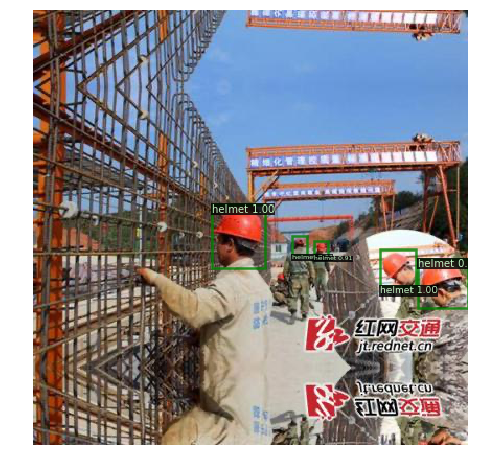

In [23]:
# coding: utf8
%matplotlib inline
import requests
import json
import cv2
import base64
import numpy as np
import colorsys
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(12,8))

def cv2_to_base64(image):
    data = cv2.imencode('.png', image)[1]
    return base64.b64encode(data.tostring()).decode('utf8')


if __name__ == '__main__':
    # 获取图片的base64编码格式
    img1 = cv2_to_base64(cv2.imread("MyDataset/images/hard_hat_workers1957.png"))
    img2 = cv2_to_base64(cv2.imread("MyDataset/images/hard_hat_workers1457.png"))
    data = {'images': [img1, img2]}
    # data = {'images': [img1]}
    # 指定content-type
    headers = {"Content-type": "application/json"}
    # 发送HTTP请求
    url = "http://127.0.0.1:8866/predict/hatdet"
    r = requests.post(url=url, headers=headers, data=json.dumps(data))

    # 打印预测结果，注意，r.json()["results"]本身就是一个数组，要取到对应图片的预测结果，需指定元素位置，如r.json()["results"][0]
    print(r.json()["results"])
    # 使用重写的visualize()方法完成预测结果后处理
    # 显示第一张图片的预测效果
    image = visualize(cv2.imread('MyDataset/images/hard_hat_workers1957.png'),r.json()["results"][0], save_dir=None)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off') # 不显示坐标轴
    plt.show()

# 下一步计划
- 安全帽佩戴检测模型在树莓派上的部署实现